In [1]:
cd /Users/lucas/repositories/myDelfi

/Users/lucas/repositories/myDelfi


In [83]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from mydelfi import ndes,mdn

In [84]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [85]:
# import data
theta_ = (np.load('/Users/lucas/Datasets/imnn_borg/score_parameters.npy').astype(np.float32))
summaries_ = np.load('/Users/lucas/Datasets/imnn_borg/score_vectors.npy').astype(np.float32)

#t2 = (np.load('./borg-imnn/regression/regression_theta2_amp.npy').astype(np.float32))
#s2 = np.load('./borg-imnn/regression/regression_x2_amp.npy').astype(np.float32)

max_om = 0.9

mask = theta_[:, 0] < max_om

theta_ = theta_[mask]
summaries_ = summaries_[mask]

#summaries_ = summaries_.reshape(summaries_.shape[0], 4)

weights = np.ones((summaries_.shape[0], 1)).astype(np.float32)


eps = 0.05

# bijector theta -> phi
theta_min = [0.1 - eps, 0.4 - eps]
theta_max = [max_om + eps, 1.6 + eps]
bijector = tfb.Blockwise([tfb.Chain([tfb.Invert(tfb.NormalCDF()), tfb.Scale(np.float32(1./(theta_max[_] - theta_min[_]))), tfb.Shift(-theta_min[_])]) for _ in range(len(theta_min))])

# phi
phi_ = bijector(theta_).numpy()

In [86]:
theta_[:, 0].min()

0.10028441

In [87]:
theta_.shape, summaries_.shape, phi_.shape

((5000, 2), (5000, 2), (5000, 2))

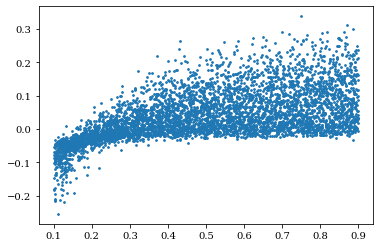

In [88]:
plt.scatter(theta_[:, 0], (summaries_[:, 0]), s=3)
#plt.axvline(0.27, color='k')
plt.show()

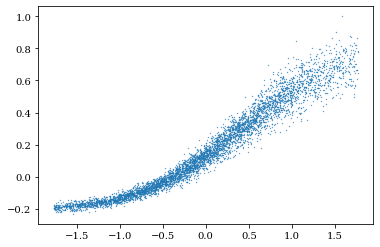

In [89]:
plt.scatter(phi_[:,1], (summaries_[:,1]), s=0.1)
plt.show()

In [90]:
theta = tf.convert_to_tensor(theta_, dtype=tf.float32)
phi   = tf.convert_to_tensor(phi_, dtype=tf.float32)
weights = tf.convert_to_tensor(weights, dtype=tf.float32)
summaries = tf.convert_to_tensor(summaries_, dtype=tf.float32)

In [153]:
# Amortized posterior
filename = './borg-imnn/moped-pk/amortized_post'
AmortizedPosterior = MixtureDensityNetwork2(n_components=3, 
                            n_conditionals=2, 
                            n_dimensions=2, 
                            optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                            n_hidden=[50, 50],
                            activation=[tf.tanh, tf.tanh])

In [166]:
#AmortizedPosterior.optimizer = tf.keras.optimizers.Adam(lr=1e-4)
historyAP = AmortizedPosterior.fit(training_conditionals=summaries, training_variables=phi, training_weights=weights, 
                        epochs=3000, batch_size=100, patience=200, save=True, filename=filename)

  7%|▋         | 203/3000 [00:26<06:10,  7.56it/s, training loss=0.689, validation_loss=0.875]


In [167]:
# reload best model
AmortizedPosterior = MixtureDensityNetwork2(n_components=6, 
                            n_conditionals=2, 
                            n_dimensions=2, 
                            optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                            n_hidden=[50, 100],
                            activation=[tf.tanh, tf.tanh],
                            restore=True,
                            restore_filename=filename)

In [168]:
summaries_obs = np.array([-0.00623568, -0.01805335]) #np.array([0.3215735 , 0.75502646]).astype(np.float32) #  [0.30336806, 0.7549215 ]

In [169]:
# plot over a grid
omegaM = np.linspace(0.11, 0.9, 70)
sigma8 = np.linspace(0.41, 1.6, 110)
OM, S8 = np.meshgrid(omegaM, sigma8)
theta_grid = np.concatenate([OM[...,np.newaxis], S8[...,np.newaxis]], axis=-1)
phi_grid = bijector(theta_grid)

cond_shape = theta_grid.shape[:-1] + (2,)

log_prob = tf.squeeze(AmortizedPosterior.log_prob(phi_grid, conditional=summaries_obs*np.ones(cond_shape).astype(np.float32))).numpy()
#log_prob = SamplingDistribution.log_prob(summaries_obs*np.ones(phi_grid.shape).astype(np.float32), conditional=theta_grid).numpy()
log_prob = log_prob - max(log_prob.flatten())

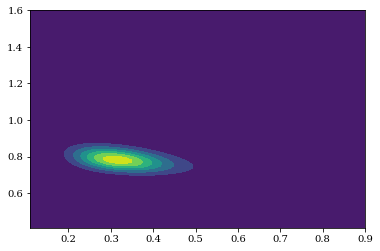

In [170]:
plt.contourf(omegaM, sigma8, np.exp(log_prob))
plt.show()

In [171]:
np.std(theta[:,0])

0.23190154

In [172]:
Posterior = AmortizedPosterior.distribution(summaries_obs[np.newaxis, :].astype(np.float32))

posterior_samples = bijector.inverse(Posterior.sample(100000)).numpy()
cut = np.all(~np.isinf(posterior_samples), axis=-1)
posterior_samples = posterior_samples[cut,:]


# cut = posterior_samples[:, 0] < 0.8
# posterior_samples = posterior_samples[cut, :]

# cut = posterior_samples[:, 0] > 0.1
# posterior_samples = posterior_samples[cut, :]

(array([8.3200e+02, 1.6458e+04, 3.9883e+04, 2.8071e+04, 9.5810e+03,
        2.7880e+03, 1.4600e+03, 7.0300e+02, 1.9900e+02, 2.5000e+01]),
 array([0.08307217, 0.16714936, 0.25122657, 0.33530375, 0.41938096,
        0.50345814, 0.5875354 , 0.67161256, 0.75568974, 0.839767  ,
        0.92384416], dtype=float32),
 <BarContainer object of 10 artists>)

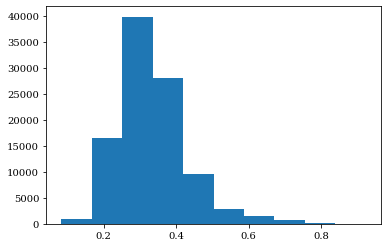

In [173]:
plt.hist(posterior_samples[:, 0])

In [174]:
import numpy as np
import h5py as h5
import matplotlib.pylab as plt
from scipy.stats import gaussian_kde

def get_data_borg(f,start):
    A1 = f['A1']
    bTA = f['bTA']
    A2 = f['A2']
    omegaM = f['omegaM']
    sigma8 = f['sigma8']
    h100 = f['h']
    return A1[start:], bTA[start:], A2[start:], omegaM[start:], h100[start:], sigma8[start:]

In [175]:
omegaM,sigma8,h100 = np.load("/Users/lucas/repositories/IMNN_vs_BORG/posterior_plots/borg_posterio_twoparam.npy").T



g = np.load('/Users/lucas/repositories/IMNN_vs_BORG/borg_runs_fixed_IA_fixed_h.npz')
A1,bTA,A2,omegaM,h100,sigma8 = get_data_borg(g,0)

omegaM_cls, s8_cls, *_ = np.load("/Users/lucas/repositories/IMNN_vs_BORG/samples_noIA.npy").T


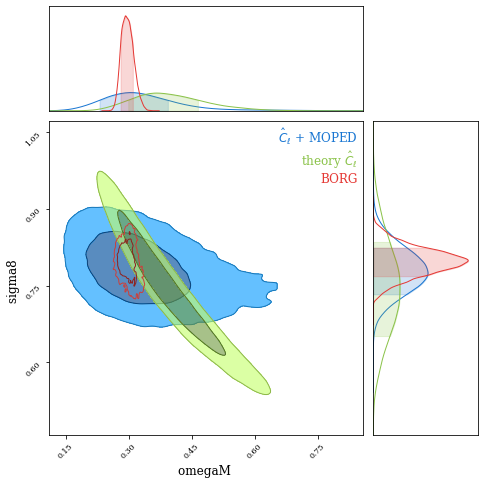

In [176]:
from chainconsumer import ChainConsumer

_psts = posterior_samples.copy()
#_psts[:, 0] = 0.3*(posterior_samples[:, 0]**2 / posterior_samples[:, 1]**2)

cs = ChainConsumer()
cs.add_chain(_psts, parameters=['omegaM', 'sigma8'], name=r'$\hat{C}_\ell$ + MOPED') #, color=corner_colors[0])

cs.add_chain(np.stack([omegaM_cls, s8_cls], -1), parameters=['omegaM', 'sigma8'], name=r'theory $\hat{C}_\ell$') #, color=corner_colors[0])

cs.add_chain(np.stack([omegaM, sigma8], axis=-1), parameters=['omegaM', 'sigma8'], name='BORG')

cs.configure(linestyles=["-", "-", "-"], linewidths=[1.0, 1.0, 1.0], usetex=False,
        shade=[True, True, False], shade_alpha=[0.7, 0.6, 0.], tick_font_size=8, sigma2d=False)
cs.plotter.plot((7,7))
plt.show()

In [ ]:
np.save('./borg-imnn/regression/results/results_wiener/posterior_samples', posterior_samples)

# now set up PIT coverage tests

for every pair (theta*, data*) in the training set, for each of the marginals compute P(theta < theta* | data*), and plot the distribution of those cumulative probabilities

In [ ]:
from tqdm import tqdm

In [ ]:
omegam_cdfs = []
sigma8_cdfs = []

for i in tqdm(range(5000)):
  theta_i = theta_[i]
  summary_i = summaries_[i]
  # could add tfp mixture model here for more than one MDN
  # p(theta | x)
  dist = AmortizedPosterior.distribution(summary_i[np.newaxis, :].astype(np.float32))
  
  samps = bijector.inverse(dist.sample(100000)).numpy()
  cut = np.all(~np.isinf(samps), axis=-1)
  samps = samps[cut,:]
  norm = samps.shape[0]


  #for each marginal
  omegam_cdfs.append(np.sum(samps[:, 0] <= theta_i[0]) / norm) 
  sigma8_cdfs.append(np.sum(samps[:, 1] <= theta_i[1]) / norm)

  #plt.hist(samps[:, 1])
  #plt.axvline(theta_i[:, 1])
  
  

 16%|█▌        | 794/5000 [01:39<08:47,  7.98it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'omegam-PIT')

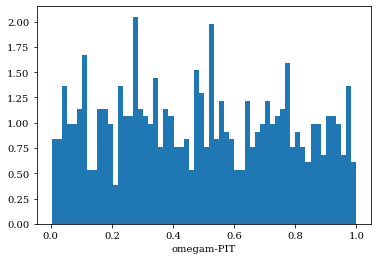

In [ ]:
plt.hist(omegam_cdfs, bins=60, density=True)
plt.xlabel('omegam-PIT')

Text(0.5, 0, 'sigma8-PIT')

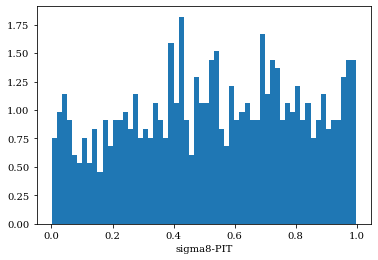

In [ ]:
plt.hist(sigma8_cdfs, bins=60, density=True)
plt.xlabel('sigma8-PIT')

In [ ]:
import cloudpickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [ ]:
import jax.numpy as jnp

In [ ]:
history = load_obj('./borg-imnn/newsims/unet/IMNN_history.pkl')

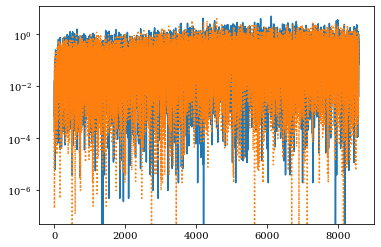

In [ ]:
plt.plot(history['detF'], linestyle='-', label="scaled train")
plt.plot(history['val_detF'], linestyle=':', label="scaled val")

plt.yscale("log")
#plt.xscale("log")

In [ ]:
history["detinvC"][-1]

Array(1.025993, dtype=float32)

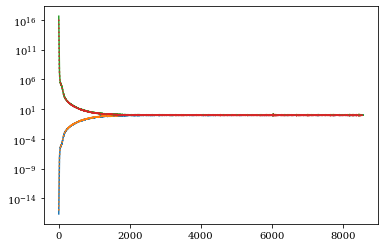

In [ ]:
plt.plot(history['detC'], linestyle='-', label="scaled train")
plt.plot(history['val_detC'], linestyle=':', label="scaled val")
plt.plot(history['detinvC'], linestyle='-', label="scaled train")
plt.plot(history['val_detinvC'], linestyle=':', label="scaled val")

plt.yscale("log")

In [ ]:
history = load_obj('./borg-imnn/scaled_net/IMNN_history.pkl')

history_old = load_obj('./borg-imnn/IMNN_history.pkl')

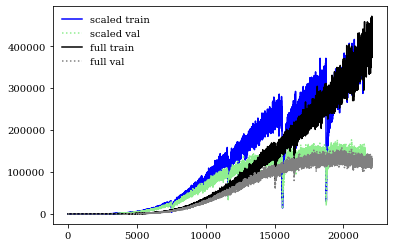

In [ ]:
plt.plot(history['detF'] , linestyle='-', color='b', label="scaled train")
plt.plot(history['val_detF'], linestyle=':', color='lightgreen', label="scaled val")

plt.plot(history_old['detF'], linestyle='-', color='k', label="full train")
plt.plot(history_old['val_detF'], linestyle=':', color='grey', label="full val")

plt.legend(framealpha=0.0)

In [ ]:
history = load_obj('./borg-imnn/sgd/IMNN_history.pkl')

history_old = load_obj('./borg-imnn/IMNN_history.pkl')

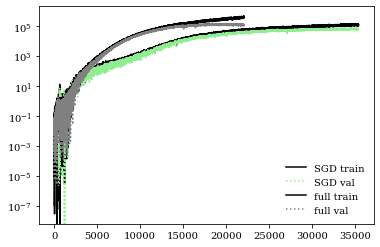

In [ ]:
plt.plot(history['detF'] , linestyle='-', color='k', label="SGD train")
plt.plot(history['val_detF'], linestyle=':', color='lightgreen', label="SGD val")

plt.plot(history_old['detF'], linestyle='-', color='k', label="full train")
plt.plot(history_old['val_detF'], linestyle=':', color='grey', label="full val")

plt.legend(framealpha=0.0)
#plt.axhline(1e5)
#plt.xscale('log')

plt.yscale('log')

In [ ]:
imnnF = np.load("./borg-imnn/sgd/IMNN_F.npy")

In [ ]:
np.linalg.det(imnnF)

72812.414

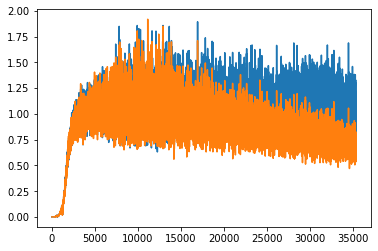

In [ ]:
plt.plot(history['detinvC'])
plt.plot(history['val_detinvC'])
#plt.xscale('log')

In [ ]:
x = np.load('./borg-imnn/regression/xfull.npy')
pms = np.load('./borg-imnn/regression/thetafull.npy')

def get_S8(omegam, sigma8):
    return sigma8 * np.sqrt(omegam / 0.3)

x_S8 = get_S8(x[:, 0], x[:, 1])
pms_S8 = get_S8(pms[:, 0], pms[:, 1])

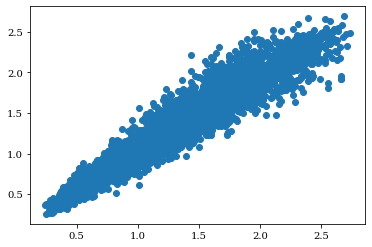

In [ ]:
plt.scatter(pms_S8[:], x_S8[:])

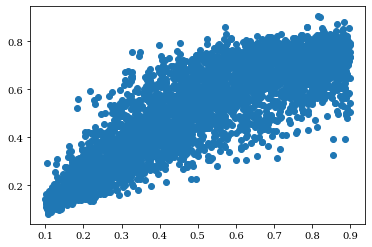

In [ ]:
plt.scatter(pms[:, 0], x[:, 0])